<a href="https://colab.research.google.com/github/meesamamir/LLM-Project/blob/main/LLM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# News Multi-Classification using NLP Techniques

This project implements a comprehensive news classification system using NLP techniques. We will use the AG News dataset, which contains news headlines labeled as follows:

0: World

1: Sports

2: Business

3: Sci/Tech

The goal is to first build a baseline classifier using logistic regression and then develop a neural network classifier for comparison.

Below, we describe each step and provide detailed comments.

# PHASE 01



In [ ]:
!pip install datasets
!pip install gensim
!pip install seaborn

!pip install numpy==1.26.4

# https://stackoverflow.com/questions/78650222/valueerror-numpy-dtype-size-changed-may-indicate-binary-incompatibility-expec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "L

In [ ]:
import numpy as np
import pandas as pd

from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import random
np.random.seed(42)

## 1 - Data Prep

### 1.1 - Data Preprocessing
We load the AG News dataset using the Huggingface datasets library. Then, we preprocess the text headlines by converting to lowercase and using CountVectorizer to convert the text into bag-of-words features. We will later report the vocabulary size and the shape of our data matrices.

TODO: Find ways to fix any training imbalances in data labels

### 1.2 - Load the AG News dataset

In [ ]:
# The default split provides train and test

from datasets import load_dataset

dataset = load_dataset("fancyzhx/ag_news")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import pandas as pd
from collections import Counter
from datasets import load_dataset

# Convert dataset to pandas DataFrame
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])

# Count labels in training and test sets
train_counts = Counter(df_train['label'])
test_counts = Counter(df_test['label'])

# Print label distribution
print("Training Set Label Counts:", train_counts)
print("Testing Set Label Counts:", test_counts)

Training Set Label Counts: Counter({2: 30000, 3: 30000, 1: 30000, 0: 30000})
Testing Set Label Counts: Counter({2: 1900, 3: 1900, 1: 1900, 0: 1900})


### 1.3 - Extract training and test texts and labels

In [ ]:
# For convenience, extract training and test texts and labels

train_texts = [example["text"] for example in dataset["train"]]
train_labels = [example["label"] for example in dataset["train"]]

test_texts = [example["text"] for example in dataset["test"]]
test_labels = [example["label"] for example in dataset["test"]]

print(f"Number of training examples (full): {len(train_texts)}")
print(f"Number of test examples: {len(test_texts)}")

Number of training examples (full): 120000
Number of test examples: 7600


### 1.4 - Add slicing of training data

Comment out the following code block to use full 120k rows for training data

In [ ]:
import random
random.seed(56)

indices = list(range(len(train_texts)))
random.shuffle(indices)

slice_indices = indices[:30000]  # Select 30k rows (approx. 25%)

# slice_indices = indices[:120000]  # Select 120k rows

train_texts = [train_texts[i] for i in slice_indices]
train_labels = [train_labels[i] for i in slice_indices]

print(f"Using {len(train_texts)} training examples for experiments.")

Using 30000 training examples for experiments.


### 1.5 - Display a snapshot of the data (first 5 rows)

In [ ]:
snapshot = pd.DataFrame({"Headline": train_texts, "Label": train_labels}).head(5)
print("Data Snapshot (first 5 rows):")
print(snapshot)

Data Snapshot (first 5 rows):
                                            Headline  Label
0  Voda plays Santa with 3G bonanza Vodafone is p...      3
1  U.N. Panel Rejects Bush Stance on Military Act...      0
2  A look at Notre Dame, Navy In week two Notre D...      1
3  RealNetworks Gets in Content Business RealNetw...      3
4  Shock as  #39;basic #39; security flaw allows ...      3


### 1.6 - Feature Extraction with Bag-of-Words / TF‑IDF
We use ***CountVectorizer*** from scikit-learn to tokenize the headlines. Text data is converted into numerical features using **CountVectorizer**

*   All words are converted to lowercase.
*   We use a minimum document frequency to filter rare tokens.

We then report the vocabulary size and the shapes of the training and test matrices.

In [ ]:
# Create a CountVectorizer with lowercase conversion and minimum document frequency threshold
vectorizer = CountVectorizer(lowercase=True, min_df=3)

# Fit on training texts and transform both training and test texts
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

# Report the vocabulary size and matrix shapes
vocab_size = len(vectorizer.vocabulary_)
print(f"\nVocabulary size: {vocab_size}\n")
print(f"Shape of training data matrix: {X_train.shape}") # (n_train, vocab_size)
print(f"Shape of test data matrix: {X_test.shape}")      # (n_test, vocab_size)



Vocabulary size: 18331

Shape of training data matrix: (30000, 18331)
Shape of test data matrix: (7600, 18331)


## 2 - Baseline Classifier: Logistic Regression

We implement a baseline logistic regression classifier.

*   First, we train without regularization.
*   Then, we train with L2 regularization.

We report the classification accuracies on the training and test sets.

### 2.1 - Logistic Regression **without** Regularization

In [ ]:
print("\n### Logistic Regression Baseline (No Regularization) ###\n")

# Instantiate logistic regression with a very high C to effectively turn off regularization
lr_no_reg = LogisticRegression(fit_intercept=True, C=1e9, solver="liblinear", max_iter=1000)

# Train the classifier
lr_no_reg.fit(X_train, train_labels)

# Predict on training and test sets
train_preds_no_reg = lr_no_reg.predict(X_train)
test_preds_no_reg = lr_no_reg.predict(X_test)

# Computing accuracy scores
train_acc_no_reg = accuracy_score(train_labels, train_preds_no_reg)
test_acc_no_reg = accuracy_score(test_labels, test_preds_no_reg)

print(f"Training Accuracy (No Reg): {train_acc_no_reg:.4f}")
print(f"Test Accuracy (No Reg): {test_acc_no_reg:.4f}")



### Logistic Regression Baseline (No Regularization) ###

Training Accuracy (No Reg): 0.9998
Test Accuracy (No Reg): 0.8687


### 2.2 - Logistic Regression with L2 Regularization

In [ ]:
print("\n### Logistic Regression Baseline (With L2 Regularization, lambda=10.0) ###\n")

# For L2 regularization with lambda=10.0, set C = 1/lambda = 0.1.
lr_reg = LogisticRegression(fit_intercept=True, C=0.1, solver="liblinear", max_iter=1000)

# Train the classifier
lr_reg.fit(X_train, train_labels)

# Predict on training and test sets
train_preds_reg = lr_reg.predict(X_train)
test_preds_reg = lr_reg.predict(X_test)

# Computing accuracy scores
train_acc_reg = accuracy_score(train_labels, train_preds_reg)
test_acc_reg = accuracy_score(test_labels, test_preds_reg)

print(f"Training Accuracy (With Reg): {train_acc_reg:.4f}")
print(f"Test Accuracy (With Reg): {test_acc_reg:.4f}")


### Logistic Regression Baseline (With L2 Regularization, lambda=10.0) ###

Training Accuracy (With Reg): 0.9463
Test Accuracy (With Reg): 0.8992


### 2.3 - Additional Evaluation (Precision, Recall, F1-score, Confusion Matrix)


In [ ]:
print("\nClassification Report (Test, With Regularization):")
print(classification_report(test_labels, test_preds_reg))

print("Confusion Matrix:")
print(confusion_matrix(test_labels, test_preds_reg))



Classification Report (Test, With Regularization):
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      1900
           1       0.94      0.97      0.96      1900
           2       0.87      0.85      0.86      1900
           3       0.87      0.88      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600

Confusion Matrix:
[[1695   66   83   56]
 [  22 1843   18   17]
 [  69   20 1623  188]
 [  61   26  140 1673]]


### 2.4 - Confusion Matrix Heatmap

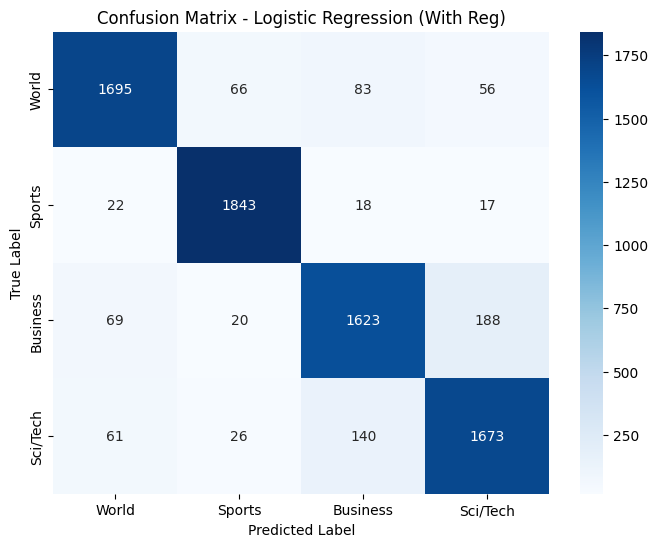

In [ ]:
import seaborn as sns

label_names = ["World", "Sports", "Business", "Sci/Tech"]
cm = confusion_matrix(test_labels, test_preds_reg)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix - Logistic Regression (With Reg)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 3 - Neural Network Classifier

Next, we implement a simple feedforward neural network classifier for the news classification task. The architecture is as follows:

1. Embedding Layer: Converts word indices to dense vectors.

2. First Hidden Layer: Sums the embeddings over the sequence and applies a linear transformation followed by a sigmoid activation.

3. Second Hidden Layer: Applies another linear transformation and sigmoid activation.

4. Output Layer: Applies a final linear transformation to predict the logits for the 4 classes, followed by softmax during evaluation.

We use PyTorch to implement the model.

Next, we will then train the network and evaluate its performance.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Setting torch seed for reproducibility
torch.manual_seed(42)


### 3.1 - Custom Dataset and DataLoader
We define a custom dataset to process news headlines. Each headline is tokenized (using a basic split), mapped to indices using the vocabulary from CountVectorizer, and then finally padded/truncated to a fixed length.

In [ ]:
# Building a word-to-index mapping from CountVectorizer's vocabulary
# Note: CountVectorizer vocabulary maps: word -> index.

vocab = vectorizer.vocabulary_

# We assume the padding index is 0. If "<pad>" is not in the vocabulary, we can use 0 as default.
# (In practice, you might add a dedicated pad token to the vocabulary.)
pad_idx = 0
default_idx = 0 # Unknown words get index 0

# Define maximum sequence length (e.g., 20 tokens)
max_seq_len_nn = 20

# Convert text to lowercase and split on whitespace.
def tokenize_text(text):
  tokens = text.lower().split()
  indices = [vocab.get(token, default_idx) for token in tokens]

  return indices


In [ ]:
class AGNewsDataset(Dataset):
  def __init__(self, texts, labels, max_len=max_seq_len_nn):
    self.texts = texts
    self.labels = labels
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    indices = tokenize_text(self.texts[idx])
    if len(indices) < self.max_len:
        indices = indices + [pad_idx] * (self.max_len - len(indices))
    else:
        indices = indices[:self.max_len]
    label = self.labels[idx]

    return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

In [ ]:
# Create dataset and DataLoader instances
train_dataset = AGNewsDataset(train_texts, train_labels, max_len=max_seq_len_nn)
test_dataset = AGNewsDataset(test_texts, test_labels, max_len=max_seq_len_nn)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### 3.2 - Neural Classifiers

In [ ]:
class NeuralClassifier(nn.Module):
  # Initialize the neural network.
  def __init__(self, vocab_size, embed_size, hidden_size, num_classes=4):

    super(NeuralClassifier, self).__init__()

    """ Initialize the neural network.
    Args:
        vocab_size (int): Size of the vocabulary.
        embed_size (int): Dimensionality of word embeddings.
        hidden_size (int): Size of hidden layers.
        num_classes (int): Number of news categories.
    """
    # Defined layers as per 'Neural Networks for NLP.pdf' slides 27-29:
        # Step 1: Embedding layer (with padding support)
        # Step 2: Linear layer from embed_size to hidden_size (first hidden layer)
        # Step 3: Second linear layer from hidden_size to hidden_size (second hidden layer)
        # Step 4: Output linear layer from hidden_size to class_size

    # Embedding layer (with padding support)
    self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)

    # 2 layers network
    self.fc1 = nn.Linear(embed_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)

    self.fc_out = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    """
    Forward pass of the model.

    Args:
        x (Tensor): Input tensor of shape [batch_size, seq_len].

    Returns:
        logits (Tensor): Logits of shape [batch_size, num_classes].
    """

    # Embedding lookup
    embedded = self.embedding(x)               # [B, L, E]

    # Sum over sequence length to create fixed-size representation
    summed = embedded.sum(dim=1)               # [B, E] fixed-size representation

    # Pass through layers with sigmoid activation
    h1 = torch.sigmoid(self.fc1(summed))       # first hidden layer
    h2 = torch.sigmoid(self.fc2(h1))           # second hidden layer

    logits = self.fc_out(h2)                   # output layer (logits)
    return logits


#### 3.2.1 Deep Neural Classifier
Adding more layers can potentially improve accuracy by allowing the network to learn more complex, abstract representations. However, deeper networks also come with increased risk of overfitting and may require careful tuning (e.g., proper regularization, dropout, and learning rate adjustments). It's worth experimenting with a deeper architecture

Things we changed for this deep model:
- We replaced **torch.sigmoid** with **F.relu**, which is less prone to saturation and allows better gradient propagation

In training:
- The dropout rate is reduced to 0.2 to retain more information while still providing regularization
- Lowering the learning rate to 0.01 can help the deeper network converge more steadily

In [ ]:
class DeepNeuralClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes=4, dropout_rate=0.5):

        super(DeepNeuralClassifier, self).__init__()
        """
        Initialize the deep neural network.

        Args:
            vocab_size (int): Size of the vocabulary.
            embed_size (int): Dimensionality of word embeddings.
            hidden_size (int): Size of hidden layers.
            num_classes (int): Number of news categories.
            dropout_rate (float): Dropout probability.
        """

        # Embedding layer (with padding support)
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)

        # 4 layers network
        self.fc1 = nn.Linear(embed_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)

        self.fc_out = nn.Linear(hidden_size, num_classes)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (Tensor): Input tensor of shape [batch_size, seq_len].

        Returns:
            logits (Tensor): Logits of shape [batch_size, num_classes].
        """
        # Get embeddings: [batch_size, seq_len, embed_size]
        embedded = self.embedding(x)

        # Mean pooling across sequence length: [batch_size, embed_size]
        pooled = embedded.mean(dim=1)

        # Pass through layers with ReLU and dropout
        h1 = F.relu(self.fc1(pooled))
        h1 = self.dropout(h1)
        h2 = F.relu(self.fc2(h1))
        h2 = self.dropout(h2)
        h3 = F.relu(self.fc3(h2))
        h3 = self.dropout(h3)
        logits = self.fc_out(h3)

        return logits


### 3.3 - Training and Evaluation Functions
We define functions for training one mini-batch and evaluating the model over an entire DataLoader.

#### 3.3.1 - Training Function:


In [ ]:
def train_batch(batch, model, optimizer):
  """ Train on one mini-batch
  Args:
    batch (tuple): (texts, labels) from DataLoader.
    model (nn.Module): Neural network.
    optimizer: Optimizer instance.

  Returns:
      loss (float): Mini-batch loss.
  """
  # set in training mode
  model.train()

  # initialize optimizer
  optimizer.zero_grad()

  # forward: prediction
  texts, labels = batch
  logits = model(texts)
  loss = F.cross_entropy(logits, labels)

  # backward: gradient computation
  loss.backward()

  # norm clipping, in case the gradient norm is too large
  torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

  # gradient-based update parameter
  optimizer.step()

  return loss.item()

#### 3.3.2 - Evaluating Function:

In [ ]:
def evaluate(loader, model):
  """ Evaluate model on given DataLoader.
  Args:
    loader (DataLoader): Evaluation data.
    model (nn.Module): Neural network.

  Returns:
    avg_loss (float): Average loss.
    accuracy (float): Classification accuracy.
  """
  model.eval()
  total_loss = 0.0
  total_correct = 0
  total_examples = 0
  with torch.no_grad():
      for texts, labels in loader:
          logits = model(texts)
          loss = F.cross_entropy(logits, labels)
          total_loss += loss.item() * texts.size(0)
          preds = torch.argmax(logits, dim=1)
          total_correct += (preds == labels).sum().item()
          total_examples += texts.size(0)
  avg_loss = total_loss / total_examples
  accuracy = total_correct / total_examples

  return avg_loss, accuracy


### 3.4 - Training Models

Hyperparameters:

- Embedding size: 64

- Hidden size: 64

- Optimizer: SGD with learning rate 0.05

- Epochs: 50 (for demonstration; increase as needed)

We record the training loss and validation performance at each epoch.

#### 3.4.1 - Training the Neural Network

In [ ]:
# Hyperparameters
embed_size = 64
hidden_size = 64
num_classes = 4
num_epochs = 50 # Increase for final training
learning_rate = 0.05

# Initialize the neural network model
model_nn = NeuralClassifier(
    vocab_size=len(vocab),
    embed_size=embed_size,
    hidden_size=hidden_size,
    num_classes=num_classes)

# Use SGD optimizer
optimizer_nn = torch.optim.SGD(
    model_nn.parameters(), lr=learning_rate)

# Record training progress
train_losses = []
val_losses = []
val_accuracies = []

print("\n### Training Neural Network Classifier ###\n")
for epoch in range(1, num_epochs + 1):
    # 1. Train for one epoch
    epoch_loss = 0.0
    for batch in train_loader:
        loss = train_batch(batch, model_nn, optimizer_nn)
        epoch_loss += loss

    # 2. Compute average training loss for this epoch
    avg_train_loss_nn = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss_nn)

    # 3. Evaluate on the test/validation set
    val_loss_nn, val_acc_nn = evaluate(test_loader, model_nn)
    val_losses.append(val_loss_nn)
    val_accuracies.append(val_acc_nn)

    # 4. Print a single summary line for this epoch
    print(f"Epoch {epoch}: "
          f"Train Loss = {avg_train_loss_nn:.4f}, "
          f"Val Loss = {val_loss_nn:.4f}, "
          f"Val Accuracy = {val_acc_nn:.4f}")

best_nn_acc = max(val_accuracies)
final_nn_acc = val_accuracies[-1]

print("\nNeural Network Training Completed.")
print(f"Best Validation Accuracy: {best_nn_acc:.4f}")
print(f"Final Validation Accuracy: {final_nn_acc:.4f}")


### Training Neural Network Classifier ###

Epoch 1: Train Loss = 1.3822, Val Loss = 1.3731, Val Accuracy = 0.3058
Epoch 2: Train Loss = 1.3595, Val Loss = 1.3400, Val Accuracy = 0.3709
Epoch 3: Train Loss = 1.3112, Val Loss = 1.2809, Val Accuracy = 0.4249
Epoch 4: Train Loss = 1.2582, Val Loss = 1.2423, Val Accuracy = 0.4416
Epoch 5: Train Loss = 1.2294, Val Loss = 1.2315, Val Accuracy = 0.4449
Epoch 6: Train Loss = 1.2141, Val Loss = 1.2149, Val Accuracy = 0.4587
Epoch 7: Train Loss = 1.2024, Val Loss = 1.2083, Val Accuracy = 0.4650
Epoch 8: Train Loss = 1.1915, Val Loss = 1.2054, Val Accuracy = 0.4672
Epoch 9: Train Loss = 1.1795, Val Loss = 1.1969, Val Accuracy = 0.4687
Epoch 10: Train Loss = 1.1682, Val Loss = 1.1855, Val Accuracy = 0.4755
Epoch 11: Train Loss = 1.1574, Val Loss = 1.1742, Val Accuracy = 0.4833
Epoch 12: Train Loss = 1.1459, Val Loss = 1.1654, Val Accuracy = 0.4905
Epoch 13: Train Loss = 1.1344, Val Loss = 1.1569, Val Accuracy = 0.4930
Epoch 14: Train Loss = 1.121

#### 3.4.2 Training the Deep Neural Network



In [ ]:
# Hyperparameters for the deep model
deep_embed_size = 64
deep_hidden_size = 64
num_epochs_deep = 50
learning_rate_deep = 0.01 # Lower the learning rate for deep nn
dropout_rate = 0.2

# Instantiate the deep neural network model
deep_model = DeepNeuralClassifier(
    vocab_size=len(vocab),
    embed_size=deep_embed_size,
    hidden_size=deep_hidden_size,
    num_classes=num_classes,
    dropout_rate=dropout_rate)

# Use SGD optimizer for deep model
optimizer_deep = torch.optim.SGD(deep_model.parameters(), lr=learning_rate_deep)

# Record training progress for deep model
deep_train_losses = []
deep_val_losses = []
deep_val_accuracies = []

print("\n### Training Deep Neural Network Classifier ###\n")
for epoch in range(1, num_epochs_deep + 1):

    # 1. Train for one epoch
    epoch_loss = 0.0
    for batch in train_loader:
        loss = train_batch(batch, deep_model, optimizer_deep)
        epoch_loss += loss

    # 2. Compute average training loss for this epoch
    avg_train_loss = epoch_loss / len(train_loader)
    deep_train_losses.append(avg_train_loss)

    # 3. Evaluate on the test/validation set
    val_loss, val_acc = evaluate(test_loader, deep_model)
    deep_val_losses.append(val_loss)
    deep_val_accuracies.append(val_acc)

    # 4. Print a single summary line for this epoch
    print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Accuracy = {val_acc:.4f}")

best_deep_acc = max(deep_val_accuracies)
final_deep_acc = deep_val_accuracies[-1]

print("\nDeep Neural Network Training Completed.")
print(f"Best Validation Accuracy (Deep): {best_deep_acc:.4f}")
print(f"Final Validation Accuracy (Deep): {final_deep_acc:.4f}")



### Training Deep Neural Network Classifier ###

Epoch 1: Train Loss = 1.3866, Val Loss = 1.3863, Val Accuracy = 0.2526
Epoch 2: Train Loss = 1.3863, Val Loss = 1.3862, Val Accuracy = 0.2574
Epoch 3: Train Loss = 1.3862, Val Loss = 1.3860, Val Accuracy = 0.2526
Epoch 4: Train Loss = 1.3861, Val Loss = 1.3858, Val Accuracy = 0.2574
Epoch 5: Train Loss = 1.3859, Val Loss = 1.3856, Val Accuracy = 0.2672
Epoch 6: Train Loss = 1.3857, Val Loss = 1.3854, Val Accuracy = 0.2666
Epoch 7: Train Loss = 1.3854, Val Loss = 1.3852, Val Accuracy = 0.2643
Epoch 8: Train Loss = 1.3852, Val Loss = 1.3850, Val Accuracy = 0.2593
Epoch 9: Train Loss = 1.3850, Val Loss = 1.3846, Val Accuracy = 0.2950
Epoch 10: Train Loss = 1.3845, Val Loss = 1.3843, Val Accuracy = 0.2841
Epoch 11: Train Loss = 1.3843, Val Loss = 1.3839, Val Accuracy = 0.2682
Epoch 12: Train Loss = 1.3837, Val Loss = 1.3834, Val Accuracy = 0.2984
Epoch 13: Train Loss = 1.3831, Val Loss = 1.3827, Val Accuracy = 0.3124
Epoch 14: Train Loss = 

In [ ]:
import pandas as pd

comparison_data = {
    "Model": ["Original NN", "Deep NN"],
    "Best Val Accuracy": [best_nn_acc, best_deep_acc],
    "Final Val Accuracy": [final_nn_acc, final_deep_acc]
}
comparison_df = pd.DataFrame(comparison_data)
print("Comparison of Neural Network Models:")
print(comparison_df)

Comparison of Neural Network Models:
         Model  Best Val Accuracy  Final Val Accuracy
0  Original NN           0.581974            0.581974
1      Deep NN           0.460921            0.460921


### 3.5 - Visualization and Summary
We plot the training and validation loss curves. In addition, note that evaluation metrics such as precision, recall, and F1-score (as well as a confusion matrix) should be computed for a thorough evaluation. For language model-based approaches, perplexity would also be computed.


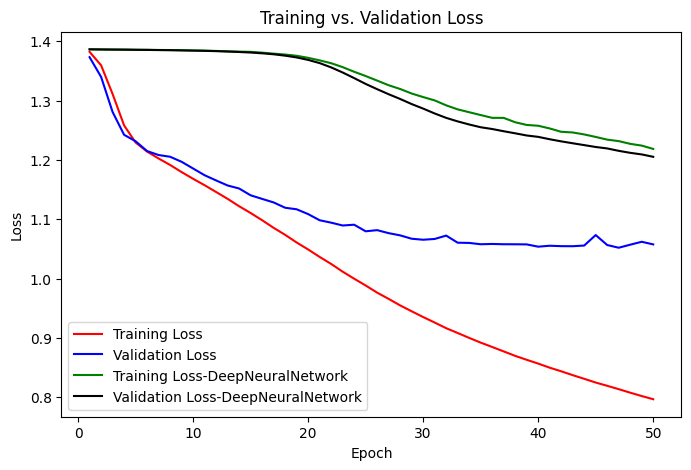

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_losses, color="red", label="Training Loss")
plt.plot(range(1, num_epochs+1), val_losses, color="blue", label="Validation Loss")

plt.plot(range(1, num_epochs+1), deep_train_losses, color="green", label="Training Loss-DeepNeuralNetwork")
plt.plot(range(1, num_epochs+1), deep_val_losses, color="black", label="Validation Loss-DeepNeuralNetwork")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

## 4 - Additional Experiments and Quantitative Analysis
This section performs further analysis on the dataset:
1. Plotting the frequency distribution of words (to check Zipf’s law).
2. Generating word embeddings using Word2Vec and displaying similar words.
3. Summarizing performance metrics in a table.

### 4.1 - Frequency Distribution Plot

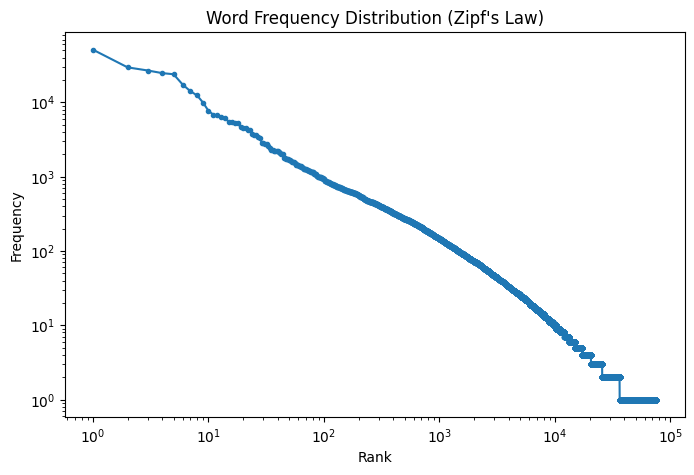

In [ ]:
# Flatten all tokens from training texts (using simple whitespace split)
all_tokens = []
for text in train_texts:
    all_tokens.extend(text.lower().split())

token_counts = Counter(all_tokens)

# Sort tokens by frequency
sorted_counts = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
tokens, frequencies = zip(*sorted_counts)

# Plot rank-frequency (log-log scale)
ranks = range(1, len(frequencies) + 1)

plt.figure(figsize=(8, 5))
plt.loglog(ranks, frequencies, marker=".")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Zipf's Law)")
plt.show()

Frequency INVERSLY PROPORTIONAL to Rank

Hence, model follows Zipf's Law

###4.2 Word Embeddings using Word2Vec

In [ ]:
!pip install gensim

In [ ]:
from gensim.models import Word2Vec

# Tokenize the training texts (simple whitespace split)
tokenized_texts = [text.lower().split() for text in train_texts]

# Train Word2Vec model (using a small dimension for demonstration)
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=50, window=5, min_count=3, workers=4, seed=42)

# Display top 5 similar words for selected keywords
keywords = ["economy", "games", "technology", "market"]
for word in keywords:
    if word in w2v_model.wv:
        similar = w2v_model.wv.most_similar(word, topn=5)
        print(f"\nTop similar words to '{word}':")
        for sim_word, score in similar:
            print(f"  {sim_word}: {score:.4f}")
    else:
        print(f"\n'{word}' not found in vocabulary.")



Top similar words to 'economy':
  economic: 0.9237
  growth: 0.8962
  spending: 0.8841
  slowing: 0.8836
  rising: 0.8740

Top similar words to 'games':
  teams: 0.9222
  playing: 0.8808
  games.: 0.8711
  game: 0.8678
  seasons: 0.8509

Top similar words to 'technology':
  services: 0.9440
  software: 0.9433
  products: 0.9402
  service: 0.9287
  management: 0.9242

Top similar words to 'market':
  price: 0.9097
  data: 0.8791
  share: 0.8752
  consumer: 0.8687
  stock: 0.8657


### 4.3 Performance Comparison Table

In [ ]:
# Create a summary table for performance metrics
import pandas as pd

# We have baseline (lr_reg) and neural network (model_nn) performance metrics.
# Here we use the test accuracy from earlier experiments.
performance_data = {
    "Model": ["Logistic Regression (With Reg)", "Neural Network"],
    "Test Accuracy": [test_acc_reg, val_accuracies[-1]]
}

performance_df = pd.DataFrame(performance_data)
print("Performance Comparison:")
print(performance_df)

Performance Comparison:
                            Model  Test Accuracy
0  Logistic Regression (With Reg)       0.899211
1                  Neural Network       0.581974


## 5 - Error Analysis - Misclassified Headlines (Logistic Regression with Reg)
Below, we discuss examples where the models fail. For instance, consider headlines that are misclassified by the baseline model.


In [ ]:
# For demonstration, print 5 misclassified examples from logistic regression with regularization
misclassified = []
for text, true_label, pred_label in zip(test_texts, test_labels, test_preds_reg):
    if true_label != pred_label:
        misclassified.append((text, true_label, pred_label))
    if len(misclassified) >= 5:
        break

print("Examples of Misclassified Headlines (Logistic Regression with Reg):")
for idx, (text, true_label, pred_label) in enumerate(misclassified, start=1):
    print(f"\nExample {idx}:")
    print(f"Headline: {text}")
    print(f"True Label: {true_label} ({label_names[true_label]})")
    print(f"Predicted Label: {pred_label} ({label_names[pred_label]})")

Examples of Misclassified Headlines (Logistic Regression with Reg):

Example 1:
Headline: Prediction Unit Helps Forecast Wildfires (AP) AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and endless charts, but already he knows what the day will bring. Lightning will strike in places he expects. Winds will pick up, moist places will dry and flames will roar.
True Label: 3 (Sci/Tech)
Predicted Label: 1 (Sports)

Example 2:
Headline: Teenage T. rex's monster growth Tyrannosaurus rex achieved its massive size due to an enormous growth spurt during its adolescent years.
True Label: 3 (Sci/Tech)
Predicted Label: 2 (Business)

Example 3:
Headline: Storage, servers bruise HP earnings update Earnings per share rise compared with a year ago, but company misses analysts' expectations by a long shot.
True Label: 3 (Sci/Tech)
Predicted Label: 2 (Business)

Example 4:
Headline: IBM to hire even more new workers By the end of the year, the computing gi

## 6 - State-of-the-Art Models – XGBoost and RandomForest

This section uses the CountVectorizer features (X_train, X_test) to train XGBoost and RandomForest classifiers.

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 5.3 MB/s eta 0:00:00


In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# XGBoost Classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train, train_labels)
xgb_test_preds = xgb_clf.predict(X_test)
xgb_test_acc = accuracy_score(test_labels, xgb_test_preds)
print("XGBoost Test Accuracy: {:.4f}".format(xgb_test_acc))

# RandomForest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, train_labels)
rf_test_preds = rf_clf.predict(X_test)
rf_test_acc = accuracy_score(test_labels, rf_test_preds)
print("RandomForest Test Accuracy: {:.4f}".format(rf_test_acc))


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:44:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Test Accuracy: 0.8793
RandomForest Test Accuracy: 0.8579


## 7 - LSTM Approach


### 7.1 - Data Preprocessing

Here we load the required libraries we will be using for the LSTM model implementation, and pre process the data

In [ ]:
!pip install tensorflow
!pip install torch
!pip install torchtext

!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import random

from collections import Counter
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
# Load the AG News dataset from Hugging Face
dataset = load_dataset("fancyzhx/ag_news")

# Convert the train and test datasets to pandas DataFrames
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])

# Print basic dataset info
print("Training Set Label Distribution:", df_train['label'].value_counts())
print("Testing Set Label Distribution:", df_test['label'].value_counts())

# Extract texts and labels (we are using the full set here; optionally, you could slice)
train_texts = [example["text"] for example in dataset["train"]]
train_labels = [example["label"] for example in dataset["train"]]

test_texts = [example["text"] for example in dataset["test"]]
test_labels = [example["label"] for example in dataset["test"]]

# Slicing the dataset to 30k rows
random.seed(42)

indices = list(range(len(train_texts)))
random.shuffle(indices)

slice_indices = indices[:30000]  # Select 30k rows (approx. 25%)

train_texts = [train_texts[i] for i in slice_indices]
train_labels = [train_labels[i] for i in slice_indices]

print(f"Using {len(train_texts)} training examples for experiments.")


Training Set Label Distribution: label
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64
Testing Set Label Distribution: label
2    1900
3    1900
1    1900
0    1900
Name: count, dtype: int64
Using 30000 training examples for experiments.


### 7.2 - Tokenization and Text Preprocessing

In this step, we will tokenize the text data, build a vocabulary, and convert the texts into sequences of indices.

In [ ]:
def tokenize_text(text):
    return text.lower().split()

# Build vocabulary from training texts
all_tokens = []
for text in train_texts:
    all_tokens.extend(tokenize_text(text))
token_counts = Counter(all_tokens)

# Create a mapping from token to index (start indexing at 1, reserve 0 for padding)
vocab = {word: idx+1 for idx, (word, _) in enumerate(token_counts.items())}
vocab_size = len(vocab) + 1  # Adding 1 for the padding token (index 0)
pad_idx = 0  # Padding token index

# Convert texts to sequences of indices
def text_to_indices(text):
    return [vocab.get(word, 0) for word in tokenize_text(text)]  # Use 0 for unknown words

train_texts_idx = [text_to_indices(text) for text in train_texts]
test_texts_idx = [text_to_indices(text) for text in test_texts]


### 7.3 - Define the Custom Dataset Classes

In [ ]:
max_seq_len_lstm = 100  # Maximum length of input sequence

class NewsDataset(Dataset):
    def __init__(self, texts, labels, max_seq_len_lstm):
        self.texts = texts
        self.labels = labels
        self.max_seq_len_lstm = max_seq_len_lstm

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Pad or truncate the sequence to max_seq_len_lstm
        text = self.texts[idx]
        if len(text) < self.max_seq_len_lstm:
            text = text + [pad_idx] * (self.max_seq_len_lstm - len(text))
        else:
            text = text[:self.max_seq_len_lstm]
        label = self.labels[idx]
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.long)

train_dataset_lstm = NewsDataset(train_texts_idx, train_labels, max_seq_len_lstm)
test_dataset_lstm = NewsDataset(test_texts_idx, test_labels, max_seq_len_lstm)

train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=64, shuffle=True)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=64, shuffle=False)


### 7.4 - Define the LSTM Model

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes, max_seq_len):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.max_seq_len = max_seq_len_lstm

    def forward(self, x):
        # x: [batch_size, seq_len]
        embedded = self.embedding(x)  # [B, seq_len, embed_size]
        lstm_out, (hn, cn) = self.lstm(embedded)
        # Use the last hidden state for classification
        out = self.fc(hn[-1])
        return out

# Hyperparameters for LSTM model
lstm_embed_size = 100
lstm_hidden_size = 128
num_classes = 4

lstm_model = LSTMClassifier(vocab_size, lstm_embed_size, lstm_hidden_size, num_classes, max_seq_len_lstm)


### 7.5 - Training and Evaluation Functions

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


In [ ]:
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

from tqdm import tqdm

def train_lstm(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct_preds = 0
    total_preds = 0
    loop = tqdm(train_loader, desc='Training LSTM', leave=False)
    for texts, labels in loop:
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)
        loop.set_postfix(loss=loss.item(), acc=100 * correct_preds / total_preds)
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

def evaluate_lstm(model, test_loader):
    model.eval()
    total_loss = 0
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for texts, labels in test_loader:
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)
    avg_loss = total_loss / len(test_loader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy


### 7.6 - Train the LSTM Model

In [ ]:
num_epochs_lstm = 50

for epoch in range(num_epochs_lstm):
    train_loss, train_acc = train_lstm(lstm_model, train_loader_lstm, optimizer_lstm, criterion)
    val_loss, val_acc = evaluate_lstm(lstm_model, test_loader_lstm)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs_lstm}")
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

final_val_loss_lstm, final_val_acc_lstm = evaluate_lstm(lstm_model, test_loader_lstm)
print(f"\nFinal Test Accuracy (LSTM): {final_val_acc_lstm:.4f}")

# Classification report and confusion matrix for LSTM predictions
lstm_model.eval()
test_preds_lstm = []
test_labels_list = []
with torch.no_grad():
    for texts, labels in test_loader_lstm:
        outputs = lstm_model(texts)
        _, preds = torch.max(outputs, dim=1)
        test_preds_lstm.extend(preds.cpu().numpy())
        test_labels_list.extend(labels.cpu().numpy())

print("LSTM Classification Report:")
print(classification_report(test_labels_list, test_preds_lstm))
print("LSTM Confusion Matrix:")
print(confusion_matrix(test_labels_list, test_preds_lstm))


Epoch 1/50
Training Loss: 1.3867, Training Accuracy: 0.2532
Validation Loss: 1.3861, Validation Accuracy: 0.2513


KeyboardInterrupt: 

In [ ]:
# Evaluate the model on the test set
val_loss, val_acc = evaluate(model, test_loader)
print(f"Final Test Accuracy: {val_acc:.4f}")

# Classification report and confusion matrix
test_preds = []
test_labels_list = []

model.eval()
with torch.no_grad():
    for texts, labels in test_loader:
        outputs = model(texts)
        _, preds = torch.max(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels_list.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(test_labels_list, test_preds))

print("Confusion Matrix:")
print(confusion_matrix(test_labels_list, test_preds))

In [ ]:
# Plot the confusion matrix heatmap
import seaborn as sns

label_names = ["World", "Sports", "Business", "Sci/Tech"]
cm = confusion_matrix(test_labels_list, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix - LSTM Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Plot training & validation loss curves
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 8 - Model Comparison Summary
Below is a summary of test accuracies for:
1. Logistic Regression (With L2 Regularization)
2. Original Neural Network Classifier
3. Deep Neural Network Classifier
4. LSTM Classifier
5. XGBoost Classifier
6. RandomForest Classifier

In [ ]:
# For the LSTM, ensure final_val_acc_lstm is defined from the previous block.

comparison_data = {
    "Model": [
        "Logistic Regression (L2 Reg)",
        "Original NN",
        "Deep NN",
        "LSTM",
        "XGBoost",
        "RandomForest"
    ],
    "Test Accuracy": [
        test_acc_reg,
        final_nn_acc,
        final_deep_acc,
        final_val_acc_lstm,
        xgb_test_acc,
        rf_test_acc
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("Performance Comparison Summary:")
print(comparison_df)


Performance Comparison Summary:
                          Model Test Accuracy
0  Logistic Regression (L2 Reg)      0.899211
1                   Original NN      0.581974
2                       Deep NN      0.460921
3                          LSTM            []
4                       XGBoost      0.879342
5                  RandomForest      0.857895


## Manual Headline Prediction for All Models

This section defines a code block where a user-entered headline is processed through all models and predictions (with confidence levels) are printed.

Enter a news headline manually and see the predictions from:
1. Baseline Logistic Regression (using CountVectorizer features)
2. Neural Network Classifier (using our custom tokenization and padding)
3.
4.
5.





In [ ]:
# Define label mapping
label_mapping = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

# Input headline (user can change this value)
headline = "Local sports team wins championship in a stunning upset"
# headline = "He bought a cruise ship on Craigslist and spent over $1 million restoring it. Then his dream sank."

# headline = "An Ohio toddler died after her mom left her home alone while she took a 10-day vacation. A judge called it the ‘ultimate act of betrayal’"

# headline = "She hit it off with the guy she met at the bar on vacation. Then he sent her an unexpected text message"



print(f"Headline: {headline}\n")

# --- Baseline Prediction using Logistic Regression ---
X_input = vectorizer.transform([headline])
probs_baseline = lr_reg.predict_proba(X_input)[0]
pred_label_baseline = lr_reg.predict(X_input)[0]
confidence_baseline = np.max(probs_baseline) * 100
print("Baseline Logistic Regression:")
print(f" Predicted Label: {pred_label_baseline} ({label_mapping[pred_label_baseline]})")
print(f" Confidence: {confidence_baseline:.2f}%\n")

# --- Original Neural Network Prediction ---
indices = tokenize_text(headline)
if len(indices) < max_seq_len_nn:
    indices = indices + [pad_idx] * (max_seq_len_nn - len(indices))
else:
    indices = indices[:max_seq_len_nn]
input_tensor = torch.tensor([indices], dtype=torch.long)
model_nn.eval()
with torch.no_grad():
    logits_nn = model_nn(input_tensor)
    probs_nn = F.softmax(logits_nn, dim=1)[0]
    pred_label_nn = torch.argmax(probs_nn).item()
    confidence_nn = probs_nn[pred_label_nn].item() * 100
print("Original Neural Network Classifier:")
print(f" Predicted Label: {pred_label_nn} ({label_mapping[pred_label_nn]})")
print(f" Confidence: {confidence_nn:.2f}%\n")

# --- Deep Neural Network Prediction ---
deep_model.eval()
with torch.no_grad():
    logits_deep = deep_model(input_tensor)
    probs_deep = F.softmax(logits_deep, dim=1)[0]
    pred_label_deep = torch.argmax(probs_deep).item()
    confidence_deep = probs_deep[pred_label_deep].item() * 100
print("Deep Neural Network Classifier:")
print(f" Predicted Label: {pred_label_deep} ({label_mapping[pred_label_deep]})")
print(f" Confidence: {confidence_deep:.2f}%\n")

# --- LSTM Classifier Prediction ---
lstm_indices = text_to_indices(headline)
if len(lstm_indices) < max_seq_len_lstm:
    lstm_indices = lstm_indices + [pad_idx] * (max_seq_len_lstm - len(lstm_indices))
else:
    lstm_indices = lstm_indices[:max_seq_len_lstm]
lstm_input = torch.tensor([lstm_indices], dtype=torch.long)
lstm_model.eval()
with torch.no_grad():
    logits_lstm = lstm_model(lstm_input)
    probs_lstm = F.softmax(logits_lstm, dim=1)[0]
    pred_label_lstm = torch.argmax(probs_lstm).item()
    confidence_lstm = probs_lstm[pred_label_lstm].item() * 100
print("LSTM Classifier:")
print(f" Predicted Label: {pred_label_lstm} ({label_mapping[pred_label_lstm]})")
print(f" Confidence: {confidence_lstm:.2f}%\n")

# --- XGBoost Prediction ---
probs_xgb = xgb_clf.predict_proba(X_input)[0]
pred_label_xgb = xgb_clf.predict(X_input)[0]
confidence_xgb = np.max(probs_xgb) * 100
print("XGBoost Classifier:")
print(f" Predicted Label: {pred_label_xgb} ({label_mapping[pred_label_xgb]})")
print(f" Confidence: {confidence_xgb:.2f}%\n")

# --- RandomForest Prediction ---
probs_rf = rf_clf.predict_proba(X_input)[0]
pred_label_rf = rf_clf.predict(X_input)[0]
confidence_rf = np.max(probs_rf) * 100
print("RandomForest Classifier:")
print(f" Predicted Label: {pred_label_rf} ({label_mapping[pred_label_rf]})")
print(f" Confidence: {confidence_rf:.2f}%\n")


Headline: Local sports team wins championship in a stunning upset

Baseline Logistic Regression:
 Predicted Label: 1 (Sports)
 Confidence: 83.46%



ValueError: too many dimensions 'str'

# PHASE 02:

Phase 2 focuses on the application of Transformer-based large language models (LLMs), such as BERT and DistilBERT, which have proven effective in numerous natural language processing tasks due to their contextual understanding and bidirectional encoding capabilities.

We implement:
- BERT
- DistilBERT, a distilled version of BERT
-	RoBERTa, an optimized variant of BERT that employs dynamic masking



In [ ]:
!pip install transformers datasets torch torchmetrics

In [ ]:
import time
import torch
from torch.utils.data import DataLoader
from transformers import (
    BertTokenizerFast, BertForSequenceClassification,
    DistilBertTokenizerFast, DistilBertForSequenceClassification,
    RobertaTokenizerFast, RobertaForSequenceClassification,
    get_linear_schedule_with_warmup
)
from datasets import load_dataset
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from torchmetrics.functional import calibration_error
import pandas as pd


## 1 - Data Prep

We want to use the same training dataset for Phase 02, as we did for Phase 01

The commented code below can be used to load the dataset as well (only for testing), but for final run, we have to use the same training dataset from Phase 01


In [ ]:
dataset = load_dataset("fancyzhx/ag_news")

train_texts = [example["text"] for example in dataset["train"]]
train_labels = [example["label"] for example in dataset["train"]]

test_texts = [example["text"] for example in dataset["test"]]
test_labels = [example["label"] for example in dataset["test"]]

print(f"Number of training examples (full): {len(train_texts)}")
print(f"Number of test examples: {len(test_texts)}")

import random
random.seed(56)

indices = list(range(len(train_texts)))
random.shuffle(indices)

slice_indices = indices[:30000]  # Select 30k rows (approx. 25%)

# slice_indices = indices[:120000]  # Select 120k rows

train_texts = [train_texts[i] for i in slice_indices]
train_labels = [train_labels[i] for i in slice_indices]

print(f"\nUsing {len(train_texts)} training examples for experiments.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Number of training examples (full): 120000
Number of test examples: 7600

Using 30000 training examples for experiments.


In [ ]:
# --------------------------------------------------------------------------------------

# Variables used in phase 01:
# train_texts, train_labels
# test_texts, test_labels

snapshot = pd.DataFrame({"Headline": train_texts, "Label": train_labels}).head(5)
print("Data Snapshot (first 5 rows):")
print(snapshot)

# Step 3: Build HF Dataset from your Phase 01 lists
train_ds = Dataset.from_dict({"text": train_texts, "label": train_labels})
test_ds  = Dataset.from_dict({"text": test_texts,  "label": test_labels})

print("\n")

print("Train size:", len(train_ds), "\nTest size:", len(test_ds))

# Bundle into a dict for compatibility with our Transformer pipeline
dataset = {"train": train_ds, "test": test_ds}

print(f"\nUsing {len(train_ds)} training examples for experiments.\n")



Data Snapshot (first 5 rows):
                                            Headline  Label
0  Voda plays Santa with 3G bonanza Vodafone is p...      3
1  U.N. Panel Rejects Bush Stance on Military Act...      0
2  A look at Notre Dame, Navy In week two Notre D...      1
3  RealNetworks Gets in Content Business RealNetw...      3
4  Shock as  #39;basic #39; security flaw allows ...      3


Train size: 30000 
Test size: 7600

Using 30000 training examples for experiments.



### 1.1 - Tokenize Function

In [ ]:
def tokenize_split(split, tokenizer):
    """
    Tokenize and encode a dataset split using a given tokenizer.
    Pads/truncates to 64 tokens.
    """
    def fn(batch):
        return tokenizer(
            batch["text"],
            padding="max_length",
            truncation=True,
            max_length=64
        )
    return split.map(fn, batched=True, batch_size=256)


### 1.2 - Prepare tokenizers and tokenized datasets

In [ ]:
bert_tok    = BertTokenizerFast.from_pretrained("bert-base-uncased")
distil_tok  = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
roberta_tok = RobertaTokenizerFast.from_pretrained("roberta-base")

for split in ["train", "test"]:
    dataset[split] = tokenize_split(dataset[split], bert_tok)
    # We only need one tokenization for training; for inference we’ll swap tokenizer as needed

# Only keep the columns we need for PyTorch
dataset["train"].set_format(type="torch", columns=["input_ids","attention_mask","label"])
dataset["test"].set_format( type="torch", columns=["input_ids","attention_mask","label"])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

### 1.3 - Create DataLoaders


In [ ]:
def make_loader(split, batch_size=16, shuffle=False):
    return DataLoader(dataset[split], batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader("train", shuffle=True)
eval_loader  = make_loader("test")


### 1.4 - Evaluation Metrics Function


In [ ]:
def compute_metrics(labels, preds, probs=None, inf_start=None):
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    cm = confusion_matrix(labels, preds)
    report = classification_report(labels, preds, zero_division=0)
    metrics = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "confusion_matrix": cm,
        "classification_report": report
    }
    if probs is not None:
        ece = calibration_error(probs=torch.tensor(probs), target=torch.tensor(labels), n_bins=10).item()
        metrics["ece"] = ece
    if inf_start:
        metrics["inference_time_s"] = time.time() - inf_start
    return metrics

def model_size_mb(model):
    total_bytes = 0
    for p in model.parameters():
        total_bytes += p.numel()*4
    return total_bytes/1e6


## 2 - Fine Tuning

In [ ]:
epochs = 3
learning_rate = 2e-5


def fine_tune(name, ModelClass, tokenizer, epochs=epochs, lr=learning_rate):
    # initialize
    model = ModelClass.from_pretrained(
        f"{name}-base-uncased" if name!="roberta" else "roberta-base",
        num_labels=4
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, 0, total_steps)

    # training
    start_train = time.time()
    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            outputs = model(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device),
                labels=batch["label"].to(device)
            )
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()
        print(f"{name} epoch {epoch} loss: {running_loss/len(train_loader):.4f}")
    train_time = time.time() - start_train

    # evaluation
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    inf_start = time.time()
    with torch.no_grad():
        for batch in eval_loader:
            logits = model(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device)
            ).logits
            probs = torch.softmax(logits, dim=1).cpu().tolist()
            preds = logits.argmax(dim=1).cpu().tolist()
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(batch["label"].tolist())

    metrics = compute_metrics(all_labels, all_preds, all_probs, inf_start)
    metrics["train_time_s"] = train_time
    metrics["model_size_MB"] = model_size_mb(model)

    return metrics, model


### 2.1 - Run experiments for BERT, DistilBERT, and RoBERTa

In [ ]:
configs = [
    ("bert",   BertForSequenceClassification,   bert_tok),
    ("distil", DistilBertForSequenceClassification, distil_tok),
    ("roberta",RobertaForSequenceClassification,    roberta_tok)
]

results = {}
models  = {}
for name, cls, tok in configs:
    print(f"\nStarting fine‐tune for {name}")
    metrics, mdl = fine_tune(name, cls, tok)
    results[name] = metrics
    models[name]  = mdl


## 3 - Summarize and display results

In [ ]:
rows = []
for name in results:
    m = results[name]
    row = {
        "Model": name,
        "Accuracy": m["accuracy"],
        "Precision": m["precision"],
        "Recall": m["recall"],
        "F1": m["f1"],
        "ECE": m.get("ece", None),
        "Train time (s)": m["train_time_s"],
        "Inf time (s)": m["inference_time_s"],
        "Size (MB)": m["model_size_MB"]
    }
    rows.append(row)

df = pd.DataFrame(rows)
print(df)


## 4 - Prompt‑based single‑headline prediction

In [ ]:
def predict_one(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=64)
    inputs = {k: v.to(model.device) for k,v in inputs.items()}
    model.eval()
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=1)[0].cpu().tolist()
    idx = probs.index(max(probs))
    return idx, max(probs)

headlineText = "New breakthrough in renewable energy announced"

labels = ["World","Sports","Business","Sci/Tech"]
for name in models:
    idx, conf = predict_one(headlineText, models[name], configs[[c[0] for c in configs].index(name)][2])
    print(f"{name}: {labels[idx]} ({conf:.2%})")


# PHASE 02 - v2.0
# Re-implementation

Phase 2 focuses on the application of Transformer-based large language models (LLMs), such as BERT and DistilBERT, which have proven effective in numerous natural language processing tasks due to their contextual understanding and bidirectional encoding capabilities.

We implement:
- BERT
- DistilBERT, a distilled version of BERT
-	RoBERTa, an optimized variant of BERT that employs dynamic masking



In [ ]:
!pip install transformers datasets torch peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Data Preparation
We'll use the AG News dataset, consistent with Phase 01, and prepare it for training.

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
from datasets import Dataset
import pandas as pd
import random

# Load dataset
dataset = load_dataset("ag_news")

# Prepare training and test data
train_texts = [example["text"] for example in dataset["train"]]
train_labels = [example["label"] for example in dataset["train"]]
test_texts = [example["text"] for example in dataset["test"]]
test_labels = [example["label"] for example in dataset["test"]]

# Sample a subset for training
random.seed(56)
indices = list(range(len(train_texts)))
random.shuffle(indices)
slice_indices = indices[:30000]  # Select 30k rows

train_texts = [train_texts[i] for i in slice_indices]
train_labels = [train_labels[i] for i in slice_indices]

# Create Hugging Face Datasets
train_ds = Dataset.from_dict({"text": train_texts, "label": train_labels})
test_ds = Dataset.from_dict({"text": test_texts, "label": test_labels})

# Combine into a dataset dictionary
dataset = {"train": train_ds, "test": test_ds}


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

## Tokenization
We'll tokenize the dataset using the appropriate tokenizer for each model.

In [ ]:
from transformers import AutoTokenizer

# Define tokenizers
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# Tokenization function
def tokenize_function(examples, tokenizer):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=64)

# Tokenize datasets
tokenized_datasets = {}
for model_name, tokenizer in [("bert", bert_tokenizer), ("distilbert", distilbert_tokenizer), ("roberta", roberta_tokenizer)]:
    tokenized_train = dataset["train"].map(lambda x: tokenize_function(x, tokenizer), batched=True)
    tokenized_test = dataset["test"].map(lambda x: tokenize_function(x, tokenizer), batched=True)
    tokenized_datasets[model_name] = {
        "train": tokenized_train,
        "test": tokenized_test
    }


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

## Model Initialization
We'll load pre-trained models from Hugging Face for BERT, DistilBERT, and RoBERTa.

In [ ]:
from transformers import AutoModelForSequenceClassification

# Load pre-trained models
bert_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)
distilbert_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)
roberta_model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=4)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Fine-Tuning with LoRA
We'll implement Low-Rank Adaptation (LoRA) for parameter-efficient fine-tuning. This technique adds trainable rank-decomposition matrices to existing weights, reducing the number of trainable parameters.

In [ ]:
from peft import get_peft_model, LoraConfig, TaskType

# For BERT
bert_lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query", "key", "value"]  # These exist in BERT
)

# For DistilBERT
distilbert_lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_lin", "v_lin"]  # Specific to DistilBERT
)

# For RoBERTa
roberta_lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query", "key", "value"]  # Same as BERT
)


In [ ]:
# Apply LoRA to models with correct config
bert_model_lora = get_peft_model(bert_model, bert_lora_config)
distilbert_model_lora = get_peft_model(distilbert_model, distilbert_lora_config)
roberta_model_lora = get_peft_model(roberta_model, roberta_lora_config)

In [ ]:
# After applying LoRA, set label mappings for each model:

for model in [bert_model_lora, distilbert_model_lora, roberta_model_lora]:
    model.config.label2id = {
        "World": 0,
        "Sports": 1,
        "Business": 2,
        "Sci/Tech": 3
    }
    model.config.id2label = {
        0: "World",
        1: "Sports",
        2: "Business",
        3: "Sci/Tech"
    }

## Training and Evaluation
We'll train and evaluate each model using the Hugging Face Trainer API.

In [ ]:
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Define compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    do_eval=True,  # Evaluate at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none"
)

# Initialize Trainer for each model
trainers = {}
for model_name, model in [("bert", bert_model_lora), ("distilbert", distilbert_model_lora), ("roberta", roberta_model_lora)]:
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets[model_name]["train"],
        eval_dataset=tokenized_datasets[model_name]["test"],
        compute_metrics=compute_metrics,
    )
    trainers[model_name] = trainer
    print(f"Training {model_name} model...")
    trainer.train()


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Training bert model...


Step,Training Loss
10,1.351700
20,1.393900
30,1.387500
40,1.370900
50,1.400700
60,1.395500
70,1.364000
80,1.375800
90,1.385500
100,1.376700


KeyboardInterrupt: 

## Prompt Tuning
We'll implement prompt tuning using the PEFT library, which adds task-specific prompts to the input and updates only these prompt parameters during training

In [ ]:
from peft import PromptTuningConfig, get_peft_model
from peft import TaskType

# Define prompt tuning configuration
prompt_config = PromptTuningConfig(
    task_type=TaskType.SEQ_CLS,
    prompt_tuning_init="TEXT",
    num_virtual_tokens=8,
    prompt_tuning_init_text="Classify the news headline into one of the categories: World, Sports, Business, Sci/Tech.",
    tokenizer_name_or_path="bert-base-uncased"
)

# Apply prompt tuning to BERT model
bert_model_prompt = get_peft_model(bert_model, prompt_config)

# Initialize Trainer
trainer_prompt = Trainer(
    model=bert_model_prompt,
    args=training_args,
    train_dataset=tokenized_datasets["bert"]["train"],
    eval_dataset=tokenized_datasets["bert"]["test"],
    compute_metrics=compute_metrics,
)

print("Training BERT model with prompt tuning...")
trainer_prompt.train()


## Evaluation and Results
After training, we'll evaluate each model's performance and compare the results.

In [ ]:
import pandas as pd

# Create a summary table
summary_rows = []

# Evaluate models
for model_name, trainer in trainers.items():
    print(f"Evaluating {model_name} model...")
    eval_results = trainer.evaluate()
    print(eval_results)

    summary_rows.append({
        "Model": model_name,
        "Accuracy": round(eval_results["eval_accuracy"] * 100, 2),
        "F1-Score": round(eval_results["eval_f1"] * 100, 2),
        "Precision": round(eval_results["eval_precision"] * 100, 2),
        "Recall": round(eval_results["eval_recall"] * 100, 2),
        "Eval Loss": round(eval_results["eval_loss"], 4)
    })

# Add prompt-tuned BERT results
summary_rows.append({
    "Model": "bert_prompt",
    "Accuracy": round(eval_results_prompt["eval_accuracy"] * 100, 2),
    "F1-Score": round(eval_results_prompt["eval_f1"] * 100, 2),
    "Precision": round(eval_results_prompt["eval_precision"] * 100, 2),
    "Recall": round(eval_results_prompt["eval_recall"] * 100, 2),
    "Eval Loss": round(eval_results_prompt["eval_loss"], 4)
})

# Create DataFrame and display
df_eval_summary = pd.DataFrame(summary_rows)
print("\nEvaluation Summary:\n")
print(df_eval_summary.to_string(index=False))

## Error Analysis
We'll analyze misclassified examples to understand where the models fail.

In [ ]:
# Get predictions for BERT model
predictions = trainers["bert"].predict(tokenized_datasets["bert"]["test"])
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

# ID to Label mapping
id2label = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}

# Identify misclassified examples
misclassified_indices = np.where(preds != labels)[0]
for idx in misclassified_indices[:5]:
    idx = int(idx)
    true_id = labels[idx]
    pred_id = preds[idx]

    print(f"Text: {dataset['test'][idx]['text']}")
    print(f"True Label: {true_id} ({id2label[true_id]}), Predicted Label: {pred_id} ({id2label[pred_id]})")
    print("---")

## Visualization Section

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from collections import Counter

In [ ]:
# Confusion Matrices
for name, tr in trainers.items():
    out  = tr.predict(tokenized[name]["test"])
    pred = np.argmax(out.predictions, axis=-1)
    lab  = out.label_ids
    cm   = confusion_matrix(lab, pred)
    plt.figure()
    plt.title(f"Confusion Matrix — {name}")
    plt.imshow(cm, aspect='equal')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(range(4), list(id2lab.values()), rotation=45)
    plt.yticks(range(4), list(id2lab.values()))
    plt.colorbar()
    plt.show()

In [ ]:
# Train vs. Validation Loss Curves
for name, tr in trainers.items():
    hist = tr.state.log_history
    # collect per‐epoch losses
    train_epochs = [h["loss"]     for h in hist if "loss"      in h and "epoch" in h and "eval_loss" not in h]
    eval_epochs  = [h["eval_loss"] for h in hist if "eval_loss" in h]
    epochs       = range(1, len(eval_epochs)+1)
    plt.figure()
    plt.plot(epochs, train_epochs, label="Train Loss")
    plt.plot(epochs, eval_epochs,  label="Val   Loss")
    plt.title(f"Loss Curves — {name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
# Zipf’s Law Word Frequency
words = " ".join(train_texts).split()
cnt   = Counter(words)
freqs = sorted(cnt.values(), reverse=True)
ranks = range(1, len(freqs)+1)
plt.figure()
plt.loglog(ranks, freqs)
plt.title("Zipf’s Law: Headline Word Frequencies")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Confidence Distribution Histogram (BERT model)
logits = preds_out.predictions
# softmax to get probabilities
exp_logits = np.exp(logits)
probs      = exp_logits / exp_logits.sum(axis=1, keepdims=True)
confidences= probs.max(axis=1)
plt.figure()
plt.hist(confidences, bins=20)
plt.title("Prediction Confidence Distribution — BERT")
plt.xlabel("Max Predicted Probability")
plt.ylabel("Count")
plt.show()